<a href="https://colab.research.google.com/github/badcortex/opt4ds/blob/master/rna_folding_opt4ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("glpk") or os.path.isfile("glpk")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq glpk-utils
    else:
        try:
            !conda install -c conda-forge glpk 
        except:
            pass

In [8]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from pyomo.environ import *
import pandas as pd
import numpy as np

# The RNA Folding problem 

**The Simple RNA Folding problem** : Given the nucleotide sequence *s* of a RNA molecule, find a *nested pairing* that pairs the *maximum* number of nucleotides, compared to any other nested pairing. 

### Integer Linear Programming formulation
The ILP formulation for the Simple RNA Folding problem will have one binary variable, called $P(i,j)$, for each pair $(i,j)$ of positions in *s*, where $i < j$. The value $P(i,j)$ given by a feasible solution to the ILP formulation whether or not the nucleotide in $i$ of *s* will be paired with the nucleotide in position $j$ of *s*. 

1. **The objective funtion** : $$ Maximize \sum_{i<j} P(i,j) $$ 
2. **The inequalities** : For every pair $(i,j)$ of positions in *s* that do not have complementary characters $$ P(i,j) = 0 $$ 
For each position $j$ in *s* $$ \sum_{k < j} P(k,j) + \sum_{k > j} P(j,k) \leq 1 $$ For every choice of four positions $i < i'< j < j'$
$$ P(i,j)+P(i',j') \leq 1 $$

See more: *Chapter 6, Integer Linear Programming in Computational and Systems Biology: An entry-level text and course, Dan Gusfield*

In [9]:
def solve_ilp_model(rna_sequence):
    rna_length = len(rna_sequence)
    
    # Model
    model = ConcreteModel()

    # Indexes
    model.I = RangeSet(1, rna_length-1)
    model.J = RangeSet(1, rna_length)

    # Decision variables
    model.P = Var(model.I, model.J, within=Binary)

    # Objective function
    model.Obj = Objective(expr=sum(model.P[i,j] for i in model.I for j in model.J if i<j),
                          sense=maximize)

    # Complementary pairs constraint
    model.ComPairs = ConstraintList()
    for j in model.J:
        for i in model.I:
            if i < j:
                if (rna_sequence[i-1], rna_sequence[j-1]) not in [("A","U"),("U","A"),("C","G"),("G","C")]:
                    model.ComPairs.add(model.P[i,j] == 0)

    # Pairing constraint 
    model.PairNucs = ConstraintList()
    for j in model.J:
        expr = 0 
        for k in range(1, j):
            expr += model.P[k,j]
        for k in range(j+1, rna_length+1):
            expr += model.P[j,k]
        model.PairNucs.add(expr <= 1)

    # Nesting contraint
    model.NestPair = ConstraintList()
    for h in range(1, rna_length-2):
        for i in range(h+1, rna_length-1):
            for j in range(i+1, rna_length):
                for k in range(j+1, rna_length+1):
                    model.NestPair.add(model.P[h,j] + model.P[i,k] <= 1)

    # Solve the model
    sol = SolverFactory("glpk").solve(model)
    time = sol["Solver"].Time

    # Print P(i,j)
    # for j in model.J:
    #    for i in model.I:
    #        if i < j:
    #            print("P({},{}) = {}".format(i, j, model.P[i,j]()))

    # Optimal solution with dot-bracket notation
    rna_db_sequence = ["." for i in rna_sequence]
    for i in model.I:
        for j in model.J:
            if i < j:
                if model.P[i,j]() == 1:
                    rna_db_sequence[i-1] = "("
                    rna_db_sequence[j-1] = ")"

    solution = {"Time": time, "ObjValue": model.Obj(), "DBSeq": rna_db_sequence}

    return solution 

### Dynamic programming: the Nussinov Algorithm

Similarly to the ILP approach, The Nussinov algorithm solves the problem of predicting secondary RNA structures by maximizing base pairs. 

"This is achieved by assigning a score to our input structure within an $L×L$ matrix, $N_{ij}$. To do this, for every paired set of nucleotides, we give it a score of $+1$, and for others, $0$. We then attempt to maximize the scores and backtrack on the nucleotides which maximize our overall score. To maximize our base pairs, Nussinov states only 4 possible rules we may use when comparing nucleotides".

**Algorithm:**
1. Add unpaired position $i$ onto best substructure for subsequence $i+1,j$
2. Add unpaired position $j$ onto best substructure for subsequence $i,j–1$
3. Add paired bases $i–j$ to the best substructure for the subsequence $i+j,j–1$
4. Combine two optimal substructures $i,k$ and $k+1,j$

$$\gamma(i, j) \; 
max \begin{cases} \gamma(i + 1, j), \\ \gamma(i, j – 1), \\ \gamma(i + 1, j – 1) + \delta(r_i, r_j), \\ max \{\gamma(i, k) + \gamma(k + 1, j) \} \end{cases}$$

where:

$$\delta(i, j) = \begin{cases} 1, & \text{if } x_i – x_j \text{is a pair} \\ 0, & \text{else.} \end{cases}$$


See more: [Nussinov algorithm to predict secondary RNA fold structures](https://bayesianneuron.com/2019/02/nussinov-predict-2nd-rna-fold-structure-algorithm/)



In [10]:
def couple(pair):
	"""
	Return True if RNA nucleotides are Watson-Crick base pairs
	"""
	pairs = {"A":"U", "U":"A", "G":"C", "C":"G"} 

	# check if pair is couplable
	if pair in pairs.items():
		return True
	
	return False

def fill(nm, rna):
	"""
	Fill the matrix as per the Nussinov algorithm
	"""
	minimal_loop_length = 0

	for k in range(1, len(rna)):
		for i in range(len(rna) - k):
			j = i + k

			if j - i >= minimal_loop_length:
				down = nm[i+1][j] # 1st rule
				left = nm[i][j-1] # 2nd rule
				diag = nm[i+1][j-1] + couple((rna[i], rna[j])) # 3rd rule

				rc = max([nm[i][t] + nm[t+1][j] for t in range(i, j)]) # 4th rule

				nm[i][j] = max(down, left, diag, rc) # max of all
			else:
				nm[i][j] = 0

	return nm	


def traceback(nm, rna, fold, i, L):
	"""
	Traceback through complete Nussinov matrix to find optimial RNA secondary structure solution through max base-pairs
	"""
	j = L

	if i < j:
		if nm[i][j] == nm[i+1][j]: # 1st rule
			traceback(nm, rna, fold, i + 1, j)
		elif nm[i][j] == nm[i][j-1]: # 2nd rule
			traceback(nm, rna, fold, i, j - 1)
		elif nm[i][j] == nm[i+1][j-1] + couple((rna[i], rna[j])): # 3rd rule
			fold.append((i, j))
			traceback(nm, rna, fold, i + 1, j - 1)
		else:
			for k in range(i+1, j-1):
				if nm[i][j] == nm[i, k] + nm[k+1][j]: # 4th rule
					traceback(nm, rna, fold, i, k)
					traceback(nm, rna, fold, k + 1, j)
					break

	return fold


def dot_write(rna, fold):
	dot = ["." for i in range(len(rna))]

	for s in fold:
		#print(min(s), max(s))
		dot[min(s)] = "("
		dot[max(s)] = ")"

	return "".join(dot)


def init_matrix(rna):
	M = len(rna)

	# init matrix
	nm = np.empty([M, M])
	nm[:] = np.NAN

	# init diaganols to 0
	# few ways to do this: np.fill_diaganol(), np.diag(), nested loop, ...
	nm[range(M), range(M)] = 0
	nm[range(1, len(rna)), range(len(rna) - 1)] = 0

	return nm

Run the following cell to fold RNA sequences with the two methods above. At the end there are graph illustrating how the times and objective values vary with changing string lengths.  


In [ ]:
if __name__ == "__main__":
    # RNA sequence
    rna_sequences = [["A","C","U","G","U"],
                     ["A","C","U","G","U","A","C","U","G","U"],
                     ["A","C","U","G","U","A","C","U","G","U","A","C","U","G","U"],
                     ["A","C","U","G","U","A","C","U","G","U","A","C","U","G","U","A","C","U","G","U"]]

    obj_value_ilp = []
    db_seq_ilp = []
    time_ilp = []

    obj_value_dp = []
    db_seq_dp = []
    time_dp = []

    for i, rna_sequence in enumerate(rna_sequences):
        # Solve ILP model
        ilp_sol = solve_ilp_model(rna_sequence)

        obj_value_ilp.append(ilp_sol["ObjValue"])
        db_seq_ilp.append("".join(ilp_sol["DBSeq"]))
        time_ilp.append(ilp_sol["Time"])

        print("#{} RNA sequence: {}\nRNA sequence length: {}\n".format(i+1,"".join(rna_sequence), len(rna_sequence)))
        print("+ ILP Model")
        print("ObjValue: {}\nDBSeq: {}\nTime: {}\n".format(obj_value_ilp[i], db_seq_ilp[i], time_ilp[i]))

        # Solve with Nussinov Algorithm
        start_time = timer() 
        nm = init_matrix("".join(rna_sequence))
        nm = fill(nm, "".join(rna_sequence))

        fold = []
        sec = traceback(nm, "".join(rna_sequence), fold, 0, len(rna_sequence) - 1)
        end_time = timer()

        res = dot_write("".join(rna_sequence), fold)

        names = [_ for _ in "".join(rna_sequence)]
        df = pd.DataFrame(nm, index=names, columns=names)	

        obj_value_dp.append(np.nanmax(nm))
        db_seq_dp.append(res)
        time_dp.append(end_time - start_time)

        print("+ Nussinov Algorithm")
        print("ObjValue: {}\nDBSeq: {}\nTime: {}\n".format(obj_value_dp[i], db_seq_dp[i], time_dp[i]))
        print(df, "\n")

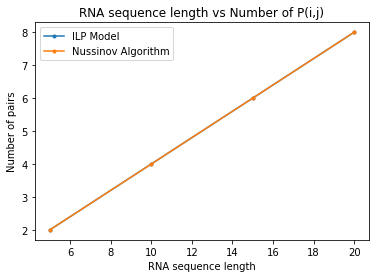

In [ ]:
fig, ax = plt.subplots()  
ax.plot([len(rna_sequence) for rna_sequence in rna_sequences], obj_value_ilp, 
        label='ILP Model', marker=".")  
ax.plot([len(rna_sequence) for rna_sequence in rna_sequences], obj_value_dp, 
        label='Nussinov Algorithm', marker=".")    
ax.set_xlabel('RNA sequence length')  
ax.set_ylabel('Number of pairs')  
ax.set_title("RNA sequence length vs Number of P(i,j)") 
ax.legend() 

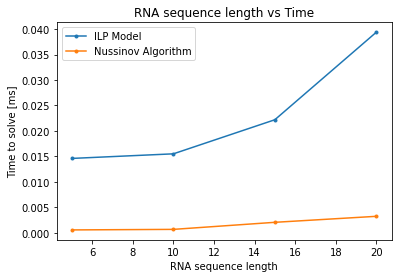

In [ ]:
fig, ax = plt.subplots()  
ax.plot([len(rna_sequence) for rna_sequence in rna_sequences], time_ilp, 
        label='ILP Model', marker=".")  
ax.plot([len(rna_sequence) for rna_sequence in rna_sequences], time_dp, 
        label='Nussinov Algorithm', marker=".")    
ax.set_xlabel('RNA sequence length')  
ax.set_ylabel('Time to solve [ms]')  
ax.set_title("RNA sequence length vs Time") 
ax.legend()

// RNA Secondary structure
digraph {
	rankdir=LR
	0 [label=A]
	1 [label=C]
	2 [label=U]
	3 [label=G]
	4 [label=U]
	0 -> 1
	1 -> 2
	2 -> 3
	3 -> 4
	0 -> 4
	1 -> 3
}


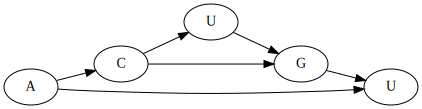

In [72]:
from graphviz import Digraph

# Visualize #1 RNA sequence optimal fold
rna_sequence = rna_sequences[0]
db_seq = db_seq_ilp[0]

# Graph creation
ss = Digraph(comment='RNA Secondary structure')
ss.attr(rankdir='LR')

for i in range(len(rna_sequence)):
    ss.node(str(i), rna_sequence[i])
    
for i in range(len(rna_sequence)-1):
    ss.edge(str(i), str(i+1))

max_length = []
for i in range(len(db_seq)-1):
    for j in range(i+1, len(db_seq)):
        if i < j:
            if db_seq[i] == "(" and db_seq[j] == ")":
                max_length.append((i,j))
              
for i in range(len(db_seq)-1):
    if db_seq[i] == "(" and db_seq[len(db_seq)-i-1] == ")":
        ss.edge(str(i), str(len(db_seq)-i-1))

print(ss.source)

ss

### Integer Linear Programming formulation with biological enhancements
The central assumption in RNA folding prediction is that the most *stable* fold is the most *likely fold*. *Base stacking* contributes significantly to the stability of an RNA fold so a more complex model (based on maximum stability) should *encourage* paired nucleotides to be organized into stacks as much as possible. 

A matched pair $(i,j)$ in a nested pairing is called *stacked pair* if either $(i+1,j-1)$ or $(i-1,j+1)$ is also a matched pair in the nested pairing. If $(i,j)$ and $(i+1,j-1)$ are stacked pairs, the four positions $(i,i+1,j-1,j)$ is called a *stacked quartet*. 

A new binary variable $Q(i,j)$ is introduced to indicate wheter the pair $(i,j)$ is the first pair in a stacked quartet.

1. **The objective funtion** : $$ Maximize \sum_{i<j} P(i,j) + Q(i,j)$$ 
2. **The inequalities** : For every pair $(i,j)$ of positions in *s* that do not have complementary characters $$ P(i,j) = 0 $$ 
For each position $j$ in *s* $$ \sum_{k < j} P(k,j) + \sum_{k > j} P(j,k) \leq 1 $$ For every choice of four positions $i < i'< j < j'$
$$ P(i,j)+P(i',j') \leq 1 $$
For each pair $(i,j)$ where $j>i$ 
$$ P(i,j) + P(i+1,j-1) - Q(i,j) \leq 1$$
$$ 2Q(i,j) - P(i,j) - P(i+1,j-1) \leq 0$$

In [14]:
from pyomo.environ import *

# RNA sequence
rna_sequence = ["A","C","C","A","G","A","G","C","C","U"]
rna_length = len(rna_sequence)
minD = 2

# Print RNA details
print("RNA sequence: {} \nRNA sequence length: {}".format("".join(rna_sequence), rna_length))

# Model
model = ConcreteModel()

# Indexes
model.I = RangeSet(1, rna_length-1)
model.J = RangeSet(1, rna_length)

# Print indexes 
# model.I.pprint()
# model.J.pprint()

# Decision variables
model.P = Var(model.I, model.J, within=Binary)
model.Q = Var(model.I, model.J, within=Binary)

# Print decision variables
# model.P.pprint()
# model.Q.pprint()

# Objective function
model.Obj = Objective(expr=sum(model.P[i,j]+model.Q[i,j] for i in model.I for j in model.J if j-i>minD),
                      sense=maximize)

# Print objective function
# model.Obj.pprint()

# Complementary pairs constraint
model.ComPairs = ConstraintList()
for j in model.J:
    for i in model.I:
        if j-1 > minD:
            if (rna_sequence[i-1], rna_sequence[j-1]) not in [("A","U"),("U","A"),("C","G"),("G","C")]:
                 model.ComPairs.add(model.P[i,j] == 0)
            
# Print complementary pairs constraint
# model.ComPairs.pprint()

# Pairing constraint 
model.PairNucs = ConstraintList()
for j in model.J:
    expr = 0 
    for k in range(1, j):
        expr += model.P[k,j]
    for k in range(j+1, rna_length+1):
        expr += model.P[j,k]
    model.PairNucs.add(expr <= 1)

# Print paired nucleotides constraints 
# model.PairNucs.pprint()

# Nesting contraint
model.NestPair = ConstraintList()
for h in range(1, rna_length-2):
    for i in range(h+1, rna_length-1):
        for j in range(i+1, rna_length):
            for k in range(j+1, rna_length+1):
                model.NestPair.add(model.P[h,j] + model.P[i,k] <= 1)

# Quartets detection
model.CountQuartet = ConstraintList()
model.IfQuartet = ConstraintList()
model.ThenQuartet = ConstraintList()
for j in model.J:
    for i in model.I:
        if j-i > minD:
            model.IfQuartet.add(model.P[i,j]+model.P[i+1,j-1]-model.Q[i,j] <= 1)
            model.ThenQuartet.add(2*model.Q[i,j]-model.P[i+1,j-1]-model.P[i,j] <= 0)
        else:
            model.CountQuartet.add(model.Q[i,j] == 0)


# Print nesting constraints                
# model.NestPair.pprint()

# Solve the model
sol = SolverFactory("glpk").solve(model)

# Basic info about the solution process
for info in sol["Solver"]:
    print(info)

# Report solution value
print("Optimal solution value: {}".format(model.Obj()))

RNA sequence: ACCAGAGCCU 
RNA sequence length: 10

Status: ok
Termination condition: optimal
Statistics: 
  Branch and bound: 
    Number of bounded subproblems: 5
    Number of created subproblems: 5
Error rc: 0
Time: 0.016323089599609375

Optimal solution value: 3.0


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title"><b>The RNA Folding Problem: An ILP Approach,</b></span> by Andrea Panno is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.<br />Based on a work at <a xmlns:dct="http://purl.org/dc/terms/" href="https://github.com/mathcoding/opt4ds" rel="dct:source">https://github.com/mathcoding/opt4ds</a>.